## Load the data

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, GlobalAveragePooling2D,LeakyReLU, BatchNormalization,Activation
from keras.regularizers import l2

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import shap

C:\Users\jpiwko\miniconda3\envs\AIAcademy\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path_to_dataset = ''
dataset = np.load(path_to_dataset, allow_pickle=True)

In [3]:
dataset[0].keys()

dict_keys(['signature', 'ts', 'range', 'azimuth', 'velocity', 'snr_db', 'x', 'y', 'z', 'class_name', 'radar_parameters', 'id'])

In [4]:
dataset[0]['signature']

array([[ -2184.474   +5562.866j  ,  -2526.5425   -156.33594j,
          6389.999    -446.359j  , ...,  -2782.7942  +2911.5913j ,
           689.9024  +7156.432j  ,   2126.5513  -5555.8486j ],
       [ -4728.104   +3039.731j  ,  -4063.7979  +1729.7131j ,
         11254.957    -832.5919j , ...,   3747.6504  +5490.9297j ,
         -2866.6526  -7649.536j  ,    839.7483  +4438.298j  ],
       [ -5771.216   +5427.785j  ,  -6739.41     +499.96533j,
         10402.633   -2605.6484j , ...,   5464.7056  +3821.1692j ,
         -4846.0938  -5117.247j  ,   2003.2429  +1375.3577j ],
       ...,
       [ 18481.121   -3017.6956j ,   6823.4556  -1022.78564j,
         -5247.8896  +2231.0557j , ...,    519.31396-10443.599j  ,
          5586.919   +4493.1865j , -13287.041   +1913.9729j ],
       [ 12855.929   +2760.175j  ,   2060.8276   +265.172j  ,
         -5769.834   +2256.358j  , ...,    871.0711  -8722.568j  ,
          4024.795   +2834.2368j , -12845.325   +6226.7144j ],
       [  4867.8184  +5988.6

In [5]:
labels = [data['class_name'] for data in dataset]
unique_classes = list(set(labels)) #unique classes in dataset
unique_classes

['person', 'vehicle', 'uav', 'bicycle']

In [6]:
for label in list(set(labels)):
    print(f'Num of {label} in dataset: {labels.count(label)}')

Num of person in dataset: 52
Num of vehicle in dataset: 201
Num of uav in dataset: 50
Num of bicycle in dataset: 47


## Preapare radar spectra

In [7]:
signatures_shape = [data['signature'].shape for data in dataset]
first_dim = [sig[0] for sig in signatures_shape]
second_dim = [sig[1] for sig in signatures_shape]

print(f'Second dimension size: {list(set(second_dim))[0]}')
print(f'First dimension size: {min(first_dim)} - {max(first_dim)}')

Second dimension size: 1008
First dimension size: 11 - 9757


In [8]:

np.median(first_dim)

178.0

In [9]:
signatures = []
labels_for_training = []

for data in tqdm(dataset):
    if (data['signature'].shape[0] >= 250):
        if (len(data['snr_db']) > 500) or (data['class_name']=="uav" and len(data['snr_db']) > 100):
            if (data['signature'].shape[0] == 250):
                signatures.append(20 * np.log10(np.abs(data['signature'])[:250,470:550]).transpose().reshape(-1,250,1))
                labels_for_training.append(data['class_name'])
            elif (data['signature'].shape[0] > 250):
                for i in range(251, data['signature'].shape[0], 20):
                    signatures.append(20 * np.log10(np.abs(data['signature'])[i-250:i,470:550]).transpose().reshape(-1,250,1))
                    labels_for_training.append(data['class_name'])
            

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [01:48<00:00,  3.21it/s]


In [10]:
signatures = np.array(signatures)

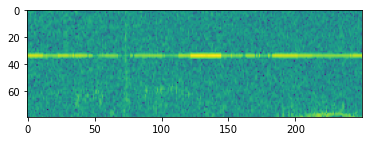

In [11]:
plt.imshow(signatures[-1])

In [12]:
signatures[-1].shape

(80, 250, 1)

## Divde dataset to train and test set

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    signatures, labels_for_training, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42)

In [14]:
X_train.shape, X_test.shape

((4360, 80, 250, 1), (935, 80, 250, 1))

In [15]:
encoder_labels = LabelEncoder()
encoder_labels = encoder_labels.fit(['person', 'bicycle', 'uav', 'vehicle'])
print("encoded labels")
print(
        f"Class 'person' is {encoder_labels.transform(['person'])[0]} and "
        f"class 'bicycle' is {encoder_labels.transform(['bicycle'])[0]} and "
        f"Class 'uav' is {encoder_labels.transform(['uav'])[0]} and "
        f"class 'vehicle' is {encoder_labels.transform(['vehicle'])[0]}")
labels_ = encoder_labels.transform(labels_for_training)
y_train = encoder_labels.transform(y_train)
y_test = encoder_labels.transform(y_test)
y_val = encoder_labels.transform(y_val)

encoded labels
Class 'person' is 1 and class 'bicycle' is 0 and Class 'uav' is 2 and class 'vehicle' is 3


In [16]:
encoder_labels = OneHotEncoder(handle_unknown='ignore')
encoder_labels = encoder_labels.fit(np.array(labels_).reshape(-1,1))
y_train = encoder_labels.transform(np.array(y_train).reshape(-1,1))
y_test = encoder_labels.transform(np.array(y_test).reshape(-1,1))
y_val = encoder_labels.transform(np.array(y_val).reshape(-1,1))

## Train simple CNN model 

In [17]:
model = Sequential()
reg =  0.0000005


model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(reg), padding='same'))
model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(reg), padding='same'))
model.add(LeakyReLU())
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(32, (3, 3), kernel_regularizer=l2(reg), padding='same'))
model.add(Conv2D(32, (3, 3), kernel_regularizer=l2(reg), padding='same'))
model.add(LeakyReLU())
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, kernel_regularizer=l2(reg)))
model.add(LeakyReLU())
model.add(Dense(16, kernel_regularizer=l2(reg)))
model.add(LeakyReLU())
model.add(Dense(8, kernel_regularizer=l2(reg)))
model.add(LeakyReLU())
model.add(Dense(4, kernel_regularizer=l2(reg)))
model.add(LeakyReLU())
model.add(Dense(4, activation='softmax'))

# model.summary()

In [18]:
X_test.shape

(935, 80, 250, 1)

In [19]:

y_train = y_train.toarray()
y_test = y_test.toarray()
y_val = y_val.toarray()

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=20) 

Epoch 1/20
137/137 [==============================] - 153s 1s/step - loss: 49.8698 - accuracy: 0.3383 - val_loss: 6.0879 - val_accuracy: 0.4679
Epoch 2/20
137/137 [==============================] - 154s 1s/step - loss: 3.1984 - accuracy: 0.3677 - val_loss: 1.3723 - val_accuracy: 0.4764
Epoch 3/20
137/137 [==============================] - 151s 1s/step - loss: 1.4200 - accuracy: 0.4674 - val_loss: 1.0592 - val_accuracy: 0.5525
Epoch 4/20
137/137 [==============================] - 148s 1s/step - loss: 1.1756 - accuracy: 0.5094 - val_loss: 1.2892 - val_accuracy: 0.6060
Epoch 5/20
137/137 [==============================] - 152s 1s/step - loss: 1.0782 - accuracy: 0.5654 - val_loss: 1.5955 - val_accuracy: 0.5899
Epoch 6/20
137/137 [==============================] - 145s 1s/step - loss: 1.1512 - accuracy: 0.5569 - val_loss: 0.9046 - val_accuracy: 0.6306
Epoch 7/20
137/137 [==============================] - 144s 1s/step - loss: 0.9172 - accuracy: 0.6156 - val_loss: 0.8649 - val_accuracy: 0.621

              precision    recall  f1-score   support

      person       0.00      0.00      0.00       154
     bicycle       0.00      0.00      0.00       435
         uav       0.24      1.00      0.39       228
     vehicle       0.00      0.00      0.00       118

    accuracy                           0.24       935
   macro avg       0.06      0.25      0.10       935
weighted avg       0.06      0.24      0.10       935



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


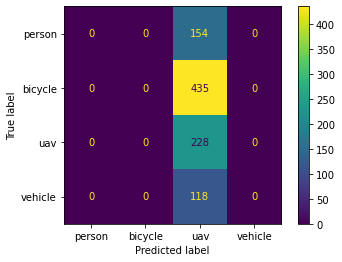

In [46]:
predicted = model.predict(X_test)
results_df = pd.DataFrame(zip(predicted, y_test), columns=['predicted', 'true'])
report_pp = classification_report(np.argmax(y_test,axis=1), np.argmax(predicted,axis=1), target_names=['person', 'bicycle', 'uav', 'vehicle'])
print(report_pp)

cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(predicted,axis=1), labels=[0,1,2,3])
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['person', 'bicycle', 'uav', 'vehicle'])
cm_display.plot()

In [22]:
e = shap.GradientExplainer(model, X_val[:10])

In [23]:
shap_values = e.shap_values(X_test[:10])

array([[[[ 84.49245 ],
         [ 78.87109 ],
         [ 81.535995],
         ...,
         [ 97.538414],
         [ 89.81011 ],
         [109.14801 ]],

        [[ 82.182686],
         [ 78.398186],
         [ 85.29686 ],
         ...,
         [111.22647 ],
         [108.26564 ],
         [109.67145 ]],

        [[ 78.80931 ],
         [ 80.54491 ],
         [ 85.80074 ],
         ...,
         [114.47776 ],
         [113.97757 ],
         [100.19307 ]],

        ...,

        [[ 84.36153 ],
         [ 79.97283 ],
         [ 87.62007 ],
         ...,
         [ 79.92263 ],
         [ 58.811516],
         [ 79.473206]],

        [[ 86.52826 ],
         [ 78.85844 ],
         [ 88.18458 ],
         ...,
         [ 73.480095],
         [ 81.54756 ],
         [ 80.64712 ]],

        [[ 84.73802 ],
         [ 80.76915 ],
         [ 87.43455 ],
         ...,
         [ 74.81363 ],
         [ 82.63653 ],
         [ 84.114716]]],


       [[[ 83.81149 ],
         [ 93.848785],
         [ 86.

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [24]:
len(shap_values), shap_values[0].shape

(4, (10, 80, 250, 1))

Actual class: uav
predicted: uav


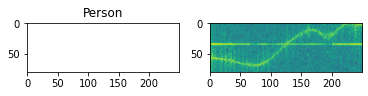

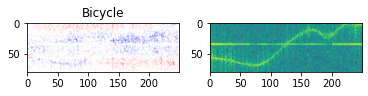

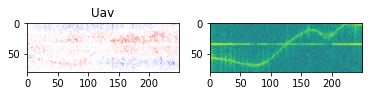

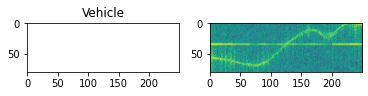

In [60]:
test_index = 0

vmin = min([i[test_index].min() for i in shap_values])
vmax = max([i[test_index].max() for i in shap_values])
print(f'Actual class: {["person", "bicycle", "uav", "vehicle"][np.argmax(y_test[test_index])]}') 
print(f'predicted: {["person", "bicycle", "uav", "vehicle"][np.argmax(predicted[test_index])]}')
plt.figure()
plt.subplot(121)
plt.title('Person')
plt.imshow(shap_values[0][test_index], cmap='bwr', vmin=vmin, vmax=vmax)
plt.subplot(122)
plt.imshow(X_test[test_index])
plt.figure()
plt.subplot(121)
plt.title('Bicycle')
plt.imshow(shap_values[1][test_index], cmap='bwr', vmin=vmin, vmax=vmax)
plt.subplot(122)
plt.imshow(X_test[test_index])
plt.figure()
plt.subplot(121)
plt.title('Uav')
plt.imshow(shap_values[2][test_index], cmap='bwr', vmin=vmin, vmax=vmax)
plt.subplot(122)
plt.imshow(X_test[test_index])
plt.figure()
plt.subplot(121)
plt.title('Vehicle')
plt.imshow(shap_values[3][test_index], cmap='bwr', vmin=vmin, vmax=vmax)
plt.subplot(122)
plt.imshow(X_test[test_index])

In [62]:
#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))

AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
# AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
# AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
# AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(4))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
# AlexNet.summary()

In [64]:
path_to_model = ''
callback = [keras.callbacks.ModelCheckpoint(
    path_to_model,
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
)]

In [21]:
AlexNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
AlexNet.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, callbacks=[callback])

Epoch 1/15
137/137 [==============================] - 85s 612ms/step - loss: 0.3514 - accuracy: 0.9110 - val_loss: 5.8124 - val_accuracy: 0.4679
Epoch 2/15
137/137 [==============================] - 86s 626ms/step - loss: 0.2215 - accuracy: 0.9608 - val_loss: 2.7435 - val_accuracy: 0.1627
Epoch 3/15
137/137 [==============================] - 82s 596ms/step - loss: 0.2047 - accuracy: 0.9619 - val_loss: 1.9230 - val_accuracy: 0.4293
Epoch 4/15
137/137 [==============================] - 83s 606ms/step - loss: 0.1378 - accuracy: 0.9807 - val_loss: 1.6692 - val_accuracy: 0.4861
Epoch 5/15
137/137 [==============================] - 81s 589ms/step - loss: 0.1345 - accuracy: 0.9766 - val_loss: 3.7892 - val_accuracy: 0.1542
Epoch 6/15
137/137 [==============================] - 81s 590ms/step - loss: 0.1024 - accuracy: 0.9862 - val_loss: 0.7776 - val_accuracy: 0.7184
Epoch 7/15
137/137 [==============================] - 80s 583ms/step - loss: 0.0993 - accuracy: 0.9849 - val_loss: 2.7172 - val_ac

              precision    recall  f1-score   support

      person       1.00      0.62      0.77       154
     bicycle       0.71      1.00      0.83       435
         uav       0.68      0.60      0.64       228
     vehicle       1.00      0.25      0.39       118

    accuracy                           0.74       935
   macro avg       0.85      0.62      0.66       935
weighted avg       0.79      0.74      0.72       935



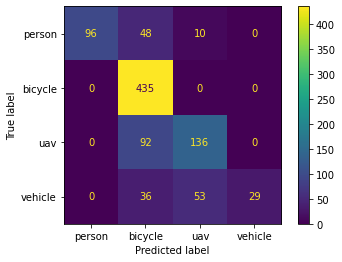

In [66]:
predicted = AlexNet.predict(X_test)
results_df = pd.DataFrame(zip(predicted, y_test), columns=['predicted', 'true'])
report_pp = classification_report(np.argmax(y_test,axis=1), np.argmax(predicted,axis=1), target_names=['person', 'bicycle', 'uav', 'vehicle'])
print(report_pp)

cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(predicted,axis=1), labels=[0,1,2,3])
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['person', 'bicycle', 'uav', 'vehicle'])
cm_display.plot()

In [68]:
e = shap.GradientExplainer(model_AlexNet, X_val[:10])

In [69]:
shap_values = e.shap_values(X_test[:10])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Actual class: uav
predicted: uav


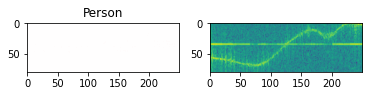

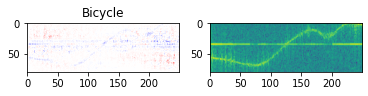

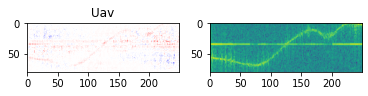

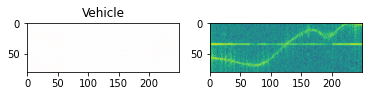

In [70]:
test_index = 0

vmin = min([i[test_index].min() for i in shap_values])
vmax = max([i[test_index].max() for i in shap_values])
print(f'Actual class: {["person", "bicycle", "uav", "vehicle"][np.argmax(y_test[test_index])]}') 
print(f'predicted: {["person", "bicycle", "uav", "vehicle"][np.argmax(predicted[test_index])]}')
plt.figure()
plt.subplot(121)
plt.title('Person')
plt.imshow(shap_values[0][test_index], cmap='bwr', vmin=vmin, vmax=vmax)
plt.subplot(122)
plt.imshow(X_test[test_index])
plt.figure()
plt.subplot(121)
plt.title('Bicycle')
plt.imshow(shap_values[1][test_index], cmap='bwr', vmin=vmin, vmax=vmax)
plt.subplot(122)
plt.imshow(X_test[test_index])
plt.figure()
plt.subplot(121)
plt.title('Uav')
plt.imshow(shap_values[2][test_index], cmap='bwr', vmin=vmin, vmax=vmax)
plt.subplot(122)
plt.imshow(X_test[test_index])
plt.figure()
plt.subplot(121)
plt.title('Vehicle')
plt.imshow(shap_values[3][test_index], cmap='bwr', vmin=vmin, vmax=vmax)
plt.subplot(122)
plt.imshow(X_test[test_index])